In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd

from PIL import Image
import glob
import cv2
import random
from pathlib import Path

from PIL import Image
import keras
import math
import random
from sklearn.model_selection import train_test_split
from keras.optimizers import SGD, Adam, RMSprop
from scipy.misc.pilutil import imresize

import os
import argparse
import json
# For deep learning functions with keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Lambda, ELU, MaxPooling2D, Activation, Dense
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import  Adam

print ("Dependency loaded!")

Using TensorFlow backend.


Dependency loaded!


## Define data path

In [2]:
# Load Udacity's data
df = pd.read_csv('data/driving_log.csv', header=0)
df.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]

# Load continued recovery data
df_recovery = pd.read_csv('data/driving_log_recovery.csv', header=0)
df_recovery.columns = ["center_image", "left_image", "right_image", "steering_angle", "throttle", "break", "speed"]

In [3]:
df_right = []
df_left = []
df_center = []
# NVIDIA's input parameters
INPUT_IMG_HEIGHT = 66
INPUT_IMG_WIDTH = 220

batch_size = 512

In [4]:
# Define the rule of processing data
sample_angles = []
def process_data(data_source):
    for i in range(len(data_source)):
        center_img = data_source["center_image"][i]
        left_img = data_source["left_image"][i]
        right_img = data_source["right_image"][i]
        angle = data_source["steering_angle"][i]
        sample_angles.append(angle)
        # Declearing data collection rule
        if (angle > 0.15):
            df_right.append([center_img, left_img, right_img, angle])

        if (angle < -0.15):
            df_left.append([center_img, left_img, right_img, angle])

        if (angle != 0):
            df_center.append([center_img, left_img, right_img, angle])
 

In [5]:
# Process recovery's data
process_data(df)

# Process recovery's data
process_data(df_recovery)

print ("Data processed")

Data processed


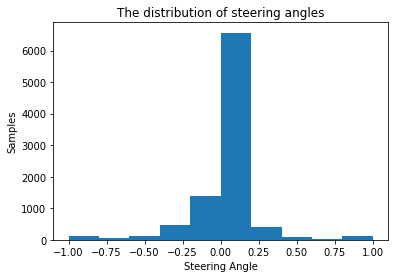

In [6]:
np_sample_angles = np.asarray(sample_angles)
a = plt.hist(np_sample_angles)
plt.xlabel('Steering Angle')
plt.ylabel('Samples')
plt.title('The distribution of steering angles')
plt.show()


In [7]:
# Shuffle data
random.shuffle(df_center)
random.shuffle(df_left)
random.shuffle(df_right)

print ("Data shuffled")

Data shuffled


In [8]:
df_center = pd.DataFrame(df_center, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_left = pd.DataFrame(df_left, columns=["center_image", "left_image", "right_image", "steering_angle"])
df_right = pd.DataFrame(df_right, columns=["center_image", "left_image", "right_image", "steering_angle"])

# Put the Left, Right & Center together
data_list = [df_center, df_left, df_right]
data_list_df = pd.concat(data_list, ignore_index=True)

In [9]:
print("Center Sample: ",len(data_list[0]))
print("Left Sample: ",len(data_list[1]))
print("Right Sample: ",len(data_list[2]))

Center Sample:  4385
Left Sample:  907
Right Sample:  1198


## Create X_train_data, X_valid_data, y_train_data, y_valid_data
## Split into Training and Validation Data

In [10]:
X_data = data_list_df[["center_image","left_image","right_image","steering_angle"]]
y_data = data_list_df["steering_angle"]

X_data = pd.DataFrame(X_data, columns=["center_image", "left_image", "right_image", "steering_angle"])
y_data = pd.DataFrame(y_data, columns=["steering_angle"])

X_train_data, X_valid_data, y_train_data, y_valid_data = train_test_split(X_data, y_data, test_size=0.2)

# Reset Index on DataFrame
X_train_data = X_train_data.reset_index(drop=True)
X_valid_data = X_valid_data.reset_index(drop=True)

## Pre-processing
### Change brightness

In [11]:
def change_brightness(image):
    # Randomly select a percent change
    change_pct = random.uniform(0.4, 1.2)

    # Change to HSV to change the brightness V
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    hsv[:,:,2] = hsv[:,:,2] * change_pct

    #Convert back to RGB
    img_bright = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    return img_bright

### Flip images

In [12]:
# Flip Image
def flip_image(image, angle):
    img_flip = cv2.flip(image,1)
    angle = -angle

    return img_flip, angle

In [13]:
def preprocessImage(image):
    # Proportionally get lower half portion of the image
    nrow, ncol, nchannel = image.shape

    start_row = int(nrow * 0.35)
    end_row = int(nrow * 0.875)

    ## This removes most of the sky and small amount below including the hood
    image_no_sky = image[start_row:end_row, :]

    # This resizes to 66 x 220 for NVIDIA's model
    new_image = cv2.resize(image_no_sky, (220,66), interpolation=cv2.INTER_AREA)

    return new_image

In [14]:
def preprocess_image_train(data_row_df):

    path_filename = data_row_df["center_image"][0]
    image = cv2.imread(path_filename)
    angle = data_row_df['steering_angle'][0]

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    image = change_brightness(image)

    # Coin flip to see to flip image and create a new sample of -angle
    if np.random.randint(2) == 1:
        image, angle = flip_image(image, angle)

    # This preprocessImage() needs to be done in drive.py
    image = preprocessImage(image)
    image = np.array(image)

    return image, angle

In [15]:
def preprocess_image_valid(data_row_df):

    path_filename = data_row_df["center_image"][0]
    angle = data_row_df['steering_angle'][0]
    image = cv2.imread(path_filename)

    image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)

    # This preprocessImage() needs to be done in drive.py
    image = preprocessImage(image)
    image = np.array(image)

    return image, angle

In [16]:
def generate_batch_train_from_dataframe(data_df, batch_size = 128):

    batch_images = np.zeros((batch_size, INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3))
    batch_angles = np.zeros(batch_size)

    while True:
        for i in range (batch_size):
            # Randomly get a sample from the input data
            idx = np.random.randint(len(data_df))

            # reset_index sets this data_df starting row to 0
            data_row = data_df.iloc[[idx]].reset_index()
            img1, angle1 = preprocess_image_train(data_row)

            batch_images[i] = img1
            batch_angles[i] = angle1

        yield batch_images, batch_angles

In [17]:
def generate_valid_from_dataframe(data_df):
    while True:
        for idx in range(len(data_df)):
            data_row = data_df.iloc[[idx]].reset_index()
            img, angle = preprocess_image_valid(data_row)

            # Since not stacking the images, it's shape remains (height, width, channel)
            # but need it to be (1, height, width, channel)
            img = img.reshape(1, img.shape[0], img.shape[1], img.shape[2])
            angle = np.array([[angle]])
            yield img, angle


In [18]:
valid_data_generator = generate_valid_from_dataframe(X_valid_data)
print("Generator initiated")

Generator initiated


In [19]:
input_shape = (INPUT_IMG_HEIGHT, INPUT_IMG_WIDTH, 3)
print("Input shape defined")

Input shape defined


In [20]:
train_data_generator = generate_batch_train_from_dataframe(X_train_data, batch_size)
val_size = len(X_valid_data)

## Model from NVIDIA

In [21]:
def nvidia_net():
    model = Sequential()

    model.add(Lambda(lambda x: x/127.5 - 1.,input_shape = input_shape))
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv1'))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv2'))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(48, 5, 5, subsample=(2, 2), border_mode="valid", init='he_normal', name='conv3'))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init='he_normal', name='conv4'))
    model.add(ELU())
    model.add(Dropout(0.5))
    
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode="valid", init='he_normal', name='conv5'))
    
    model.add(Flatten(name='flatten1'))
    model.add(ELU())
    model.add(Dense(1164, init='he_normal', name='dense1'))
    model.add(ELU())
    model.add(Dense(100, init='he_normal', name='dense2'))
    model.add(ELU())
    model.add(Dense(50, init='he_normal', name='dense3'))
    model.add(ELU())
    model.add(Dense(10, init='he_normal', name='dense4'))
    model.add(ELU())
    model.add(Dense(1, init='he_normal', name='dense5'))

    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(optimizer=adam, loss='mse')

    return model

In [22]:
model_test = nvidia_net()
model_test.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 66, 220, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 108, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
elu_1 (ELU)                      (None, 31, 108, 24)   0           conv1[0][0]                      
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 31, 108, 24)   0           elu_1[0][0]                      
___________________________________________________________________________________________

In [23]:
val_size = len(X_valid_data)
batch_size = 512

idx_best = 0
val_best = 9999

In [24]:
def save_model(fileModelJSON, fileWeights):
    prefix = "model/"
    
    filenameJSON = prefix + fileModelJSON
    if Path(filenameJSON).is_file():
        os.remove(filenameJSON)    
    with open (filenameJSON, 'w') as outfile:
        json.dump(model.to_json(), outfile)
        
    filenameWeights = prefix + fileWeights
    if Path(filenameWeights).is_file():
        os.remove(filenameWeights)
    model.save_weights(filenameWeights, True)
    

In [25]:
for idx in range(3):
    train_data_generator = generate_batch_train_from_dataframe(X_train_data, batch_size)
    model = nvidia_net()
    history = model.fit_generator(train_data_generator, samples_per_epoch=20480,
                                 nb_epoch=6, validation_data=valid_data_generator,
                                 nb_val_samples=val_size)
    
    fileModelJSON = 'model_nvidia_v2' + str(idx) + '.json'
    fileWeights = 'model_nvidia_v2' + str(idx) + '.h5'
    save_model(fileModelJSON, fileWeights)
    
    val_loss = history.history['val_loss'][0]
     # Choose the best fit
    if val_loss < val_best:
        val_best = val_loss
        idx_best = idx

print("Best model found at idx:", idx_best)
print("Best Validation score:", val_best)
 

Epoch 1/6
20480/20480 [==============================] - 168s - loss: 1.6382 - val_loss: 1.8028

In [26]:
from IPython.display import HTML
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('run.mp4'))